In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [52]:
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.Experimental_methods.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
import torch
from TargetDistributions.MoG import MoG
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.utils import plot_distributions, plot_samples
torch.set_default_dtype(torch.float64)

# Specifiy target distribution and key param

## MoG

In [53]:
torch.manual_seed(2)
epochs = 500
dim = 6
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=1, loc_scaling=5)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
if dim == 2:
    fig = plot_distribution(target, bounds=[[-30, 20], [-20, 20]])

tensor(51.6871)


# Setup AIS training

In [54]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=10.0) #, flow_type="RealNVP")
tester = AIS_trainer(target, learnt_sampler, loss_type="kl", n_distributions=20, n_updates_Metropolis=3,
                    noise_scaling=1.0)

### Visualisation before training
Let's look at the effective sample size before training of vanilla IS vs annealed IS

In [55]:
n_samples = 10000

In [56]:
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = \
    vanilla_IS.calculate_expectation(n_samples, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation_vanilla}")
print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples}, \
      var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

true expectation is 51.68707930845954, estimated expectation is 157.53881498402689
ESS is 0.0016075672653138987,       var is 6.211200643449585e-06


true expectation is 51.68707930845954, estimated expectation is 58.11861557755142
ESS is 0.008683233163562683, var is 1.1417589393028823e-06


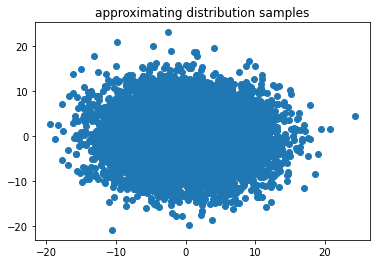

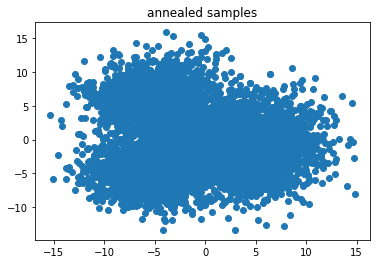

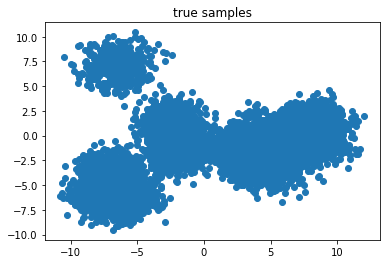

In [57]:
with torch.no_grad():
    expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples,
                                                                    expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(
    f"ESS is {info_dict['effective_sample_size'] / n_samples}, "
    f"var is {torch.var(info_dict['normalised_sampling_weights'])}")

plt.figure()
learnt_dist_samples = learnt_sampler.sample((n_samples,)).cpu().detach()
plt.scatter(learnt_dist_samples[:, 0], learnt_dist_samples[:, 1])
plt.title("approximating distribution samples")
plt.show()
plt.figure()
plt.scatter(info_dict["samples"][:, 0].cpu(), info_dict["samples"][:, 1].cpu())
plt.title("annealed samples")
plt.show()
plt.figure()
true_samples = target.sample((n_samples,)).cpu().detach()
plt.scatter(true_samples[:, 0], true_samples[:, 1])
plt.title("true samples")
plt.show()

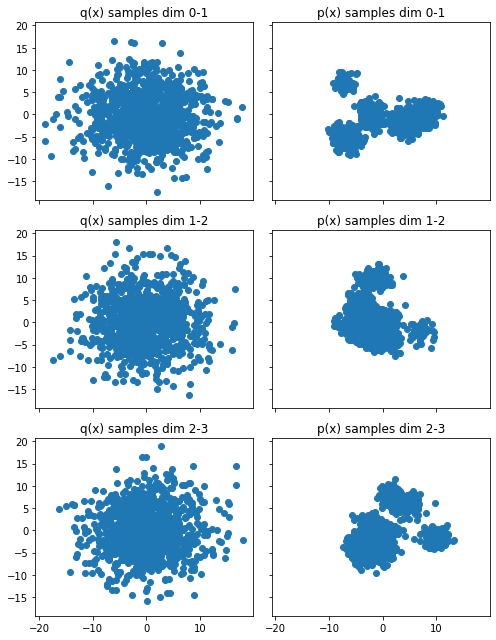

In [58]:
plot_samples(tester)

# Now let's train

In [59]:
history = tester.train(500, batch_size=1000)

loss: 8.603494245612842, mean log p_x -20.59883736800961:  17%|█▋        | 83/500 [12:39<1:03:36,  9.15s/it]  


ValueError: The value argument must be within the support

In [ ]:
plot_history(history)

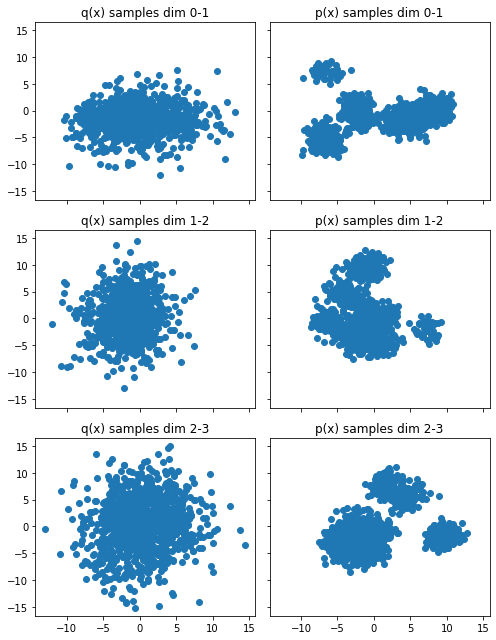

In [60]:
plot_samples(tester)